# Import libraries

In [1]:
from os.path import expanduser
from importlib.machinery import SourceFileLoader
from scipy.stats import mannwhitneyu, beta, binom, poisson
from math import lgamma

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D 
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd 
import itertools
import multiprocessing as mp 
import re
import os

from datetime import datetime

# load custom flu and ngs libraries 
laeb_lib = expanduser("../python_lib") # folder where custom libraries are saved 
fc = SourceFileLoader('fc', "%s/flu_common.py"%(laeb_lib)).load_module()
ngs = SourceFileLoader('ngs', "%s/laeb_ngs_pipeline.py"%(laeb_lib)).load_module()

# Inputs 

In [8]:
# inputs 
# file path to data folder - fastq files to be analysed must be in {data folder}/raw
data_folder = './data' 
# reference fasta file name (should be placed in input_folder)
ref_fasta_fname = './input/H1N1pdm09_Cali09.fasta' 
# CSV file containing the CDR regions of each gene segment (numbering should be based on that of the given reference sequence)
cds_coords = "./input/CDS_H1N1pdm09_Cali09.csv"
nucpos_shift = "./input/CDS_shift_H1N1pdm09_Cali09.csv"
# file path to metadata file. 
meta_fname = './results/metadata_w_covbreadth.csv' 

# mapping options
threadnum = 4 # number of CPU threads for parallelization 
base_qual_threshold = 20 # minimum accepted base quality 
max_indel_prop = 0.05 # max tolerable proportion of indels wrt read length 
max_indel_abs = 10 # max tolerable absolute number of indels 

# variant calling options
Query_HAnum_subtype = 'absH1pdm' # query HA numbering subtype (i.e. numbering based on CDR HA protein )
HAnum_subtype = 'H3' # reporting HA numbering subtype
subtype_ant = 'H1ant'  # HA canonical antigenic site of interest 
min_cov = 50 # minimum coverage 
min_var_freq = 0
min_var_prop = 0.02 # minimum variant proportion 
err_tol = 0.01 # threshold to which variant called could result from base calling error 
min_breadth = 0.7 # min breadth of gene segment to be mapped for further analysis 

date_format = "%d/%m/%y"

# Parameters and functions 

Parameters needed by the pipeline. No need to change any of this section except maybe for the file path of ```HA_numbering_conversion.csv``` used for literally HA numbering conversion (currently in ```./inputs/HA_numbering_conversion.csv```). 

In [9]:
# presets 
reffasta = ref_fasta_fname

# initialise
gene_to_proteinorf, influenza_gene_len, sorted_refnames, nucpos_shift = ngs.initialisation(cds_coords, reffasta, laeb_lib, nucpos_shift=nucpos_shift)
display (gene_to_proteinorf.head())

ha_numbering_conversion = pd.read_csv(expanduser('%s/HA_numbering_conversion.csv'%(laeb_lib)),
                                      na_values='-')
ha_numbering_conversion = ha_numbering_conversion.set_index(Query_HAnum_subtype)
display (ha_numbering_conversion.head())

codon_table = {
            'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
            'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
            'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
            'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',}
all_bases = ['A', 'T', 'G', 'C']


Initialising CDS coordinates...

Check translated protein sequences...
PB2 MERIKELRDLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPALRMKWMMAMRYPITADKRIMDMIPERNEQGQTLWSKTNDAGSDRVMVSPLAVTWWNRNGPTTSTVHYPKVYKTYFEKVERLKHGTFGPVHFRNQVKIRRRVDTNPGHADLSAKEAQDVIMEVVFPNEVGARILTSESQLAITKEKKEELQDCKIAPLMVAYMLERELVRKTRFLPVAGGTGSVYIEVLHLTQGTCWEQMYTPGGEVRNDDVDQSLIIAARNIVRRAAVSADPLASLLEMCHSTQIGGVRMVDILRQNPTEEQAVDICKAAIGLRISSSFSFGGFTFKRTSGSSVKKEEEVLTGNLQTLKIRVHEGYEEFTMVGRRATAILRKATRRLIQLIVSGRDEQSIAEAIIVAMVFSQEDCMIKAVRGDLNFVNRANQRLNPMHQLLRHFQKDAKVLFQNWGIESIDNVMGMIGILPDMTPSTEMSLRGIRVSKMGVDEYSSTERVVVSIDRFLRVRDQRGNVLLSPEEVSETQGTEKLTITYSSSMMWEINGPESVLVNTYQWIIRNWEIVKIQWSQDPTMLYNKMEFEPFQSLVPKATRSRYSGFVRTLFQQMRDVLGTFDTVQIIKLLPFAAAPPEQSRMQFSSLTVNVRGSGLRILVRGNSPVFNYNKATKRLTVLGKDAGALTEDPDEGTSGVESAVLRGFLILGKEDKRYGPALSINELSNLAKGEKANVLIGQGDVVLVMKRKRDSSILTDSQTATKRIRMAIN*
PB1 MDVNPTLLFLKIPAQNAISTTFPYTGDPPYSHGTGTGYTMDTVNRTHQYSEKGKWTTNTETGAPQLNPIDGPLPEDNEPSGYAQTDCVLEAMAFLEESHPGIFENSCLETMEVVQQTRVDKLTQGRQTYDWTLNRNQPAATALANTIEVFRSNGLTANE

aa  frame
gene  nuc protein           
1-PB2 1   PB2       1      1
      2   PB2       1      2
      3   PB2       1      3
      4   PB2       2      1
      5   PB2       2      2

,H3,absH3,absH5,H1N1pdm,H5,H5c221,H1ant,H3ant,RBS
absH1pdm,,,,,,,,,
1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0
2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0
3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,0
4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,0
5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,0


# Read metadata and variant calling files

In [10]:
# metadata 
## metadata must have 'sampid' header which is used as sample identifier 
meta_df = pd.read_csv('%s'%meta_fname)
meta_df = meta_df[meta_df["sampid"]!='3-12'] 
sorted_sampid = sorted(set(meta_df['sampid']))

meta_df = meta_df.set_index("sampid")
display (meta_df.head())

# vcf 
variant_call_df = pd.read_csv("./results/variant_call_MinCoV%i_MinProp%.2f_MinFreq%i_ErrTol%.2f.csv"%(min_cov, min_var_prop, min_var_freq, err_tol))
variant_call_df['protein'] = variant_call_df['protein'].fillna("NA")
variant_call_df = variant_call_df.set_index(["sampid", 'gene'])
display (variant_call_df.head())

,subject_id,enrolD,household,date,project,short_name,CT,age,sex,timepoint,...,ost_ed,ost_days,1-PB2,2-PB1,3-PA,4-HA,5-NP,6-NA,7-M,8-NS
sampid,,,,,,,,,,,,,,,,,,,,,
3-20,11-001,0,NaN,13/11/09,Hanoi,11-001-d0,17.00,10.0,Female,2.0,...,11.0,1;11,1.000000,0.978012,1.000000,0.970606,1.000000,1.0,1.0,1.0
3-22,11-002,0,NaN,17/11/09,Hanoi,11-002-d0,17.28,18.0,Female,4.0,...,13.0,3;13,1.000000,1.000000,1.000000,0.985303,1.000000,1.0,1.0,1.0
3-24,11-006,2,NaN,12/11/09,Hanoi,11-006-d2,27.42,38.5,Male,4.0,...,9.0,1;9,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
3-1,11-1015,0,NaN,22/10/09,Hanoi,11-1015-d0,25.00,39.4,Female,2.0,...,7.0,3;7,0.945175,0.956025,1.000000,1.000000,1.000000,1.0,1.0,1.0
3-3,11-1015,4,NaN,27/10/09,Hanoi,11-1015-d4,33.09,39.4,Female,7.0,...,7.0,3;7,0.320175,0.098505,0.198047,0.764844,0.832999,1.0,1.0,1.0


nucpos nuc_var  nuc_prop  nuc_freq nuc_consensus  \
sampid gene                                                     
2-17   3-PA     204       A  0.153846        14             G   
       3-PA     204       A  0.153846        14             G   
       3-PA    1321       C  0.142857        12             A   
       3-PA    1848       A  0.130435        12             G   
       4-HA     249       A  0.044776         3             G   

             nuc_consensus_freq  nuc_coverage protein  aapos HA_num_type  \
sampid gene                                                                
2-17   3-PA                  77            91      PA     68         NaN   
       3-PA                  77            91    PA-X     68         NaN   
       3-PA                  72            84      PA    441         NaN   
       3-PA                  80            92      PA    616         NaN   
       4-HA                  64            67      HA     75          H3   

            aa_var   aa_prop  aa_freq expected_aa_consensus aa_consensus  \
sampid gene                                                                
2-17   3-PA      P  0.162791     14.0                     P            P   
       3-PA      P  0.162791     14.0                     P            P   
       3-PA      L  0.148148     12.0                     M            M   
       3-PA      S  0.134831     12.0                     S            S   
       4-HA      E  0.044776      3.0                     E            E   

             aa_consensus_freq  aa_coverage  codon_pos codon  nonsyn  
sampid gene                                                           
2-17   3-PA               72.0         86.0          3   CCA     0.0  
       3-PA               72.0         86.0          3   CCA     0.0  
       3-PA               69.0         81.0          1   CTG     1.0  
       3-PA               77.0         89.0          3   TCA     0.0  
       4-HA               64.0         67.0          3   GAA     0.0

# Analyze transmission pairs among household samples

In [14]:
# function to compute L1 norm distance between any two sample pairs
def compute_L1_norm(s1_sampid, s2_sampid):
    
    s1_map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(s1_sampid)).set_index(['Gene', 'Position'])
    s2_map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(s2_sampid)).set_index(['Gene', 'Position'])
    
    gene_to_l1_norm = []
    for gene in sorted_refnames: 
        # go through each gene 
        gene_s1_map_nuc_results = s1_map_nuc_results.loc[gene]
        gene_s2_map_nuc_results = s2_map_nuc_results.loc[gene]
        
        # >= min_cov 
        gene_s1_map_nuc_results = gene_s1_map_nuc_results[gene_s1_map_nuc_results['Coverage']>=min_cov]
        gene_s2_map_nuc_results = gene_s2_map_nuc_results[gene_s2_map_nuc_results['Coverage']>=min_cov]
        
        # overlapping pos_range
        pos_range = np.array(sorted(set(gene_s1_map_nuc_results.index)&set(gene_s2_map_nuc_results.index)))
        pos_range = pos_range[pos_range>0] # cdr region only 
        
        # vcf 
        try: 
            s1_vcf = variant_call_df.loc[(s1_sampid, gene)]
            s1_varpos_list = list(s1_vcf.index)
        except: 
            s1_varpos_list = []
            
        try: 
            s2_vcf = variant_call_df.loc[(s2_sampid, gene)]
            s2_varpos_list = list(s2_vcf.index)
        except: 
            s2_varpos_list = []
            
        l1_norm_dist = 0
        
        for nucpos in pos_range: 
            nucpos_gene_s1_map_nuc_results = gene_s1_map_nuc_results.loc[nucpos].copy()
            nucpos_gene_s2_map_nuc_results = gene_s2_map_nuc_results.loc[nucpos].copy()
            
            if nucpos in s1_varpos_list: 
                # polymorphic site - only those verified by vcf + consensus 
                nucpos_s1_vcf = s1_vcf.loc[nucpos]
                if isinstance(nucpos_s1_vcf, pd.Series): 
                    nucpos_s1_vcf = nucpos_s1_vcf.to_frame().T
                nucpos_s1_vcf = nucpos_s1_vcf.drop_duplicates("nuc_var")
                nucpos_s1_varlist = list(nucpos_s1_vcf["nuc_var"])+[nucpos_s1_vcf['nuc_consensus'].iloc[0]]               
            else: 
                # non polymorphic site - consensus = coverage 
                nucpos_s1_varlist = list(nucpos_gene_s1_map_nuc_results['Consensus'])
            
            nucpos_s1_bcounts = nucpos_gene_s1_map_nuc_results[all_bases]
            nucpos_s1_bcounts.loc[set(all_bases)-set(nucpos_s1_varlist)] = 0
            try: 
                s1_var_prop_array = (nucpos_s1_bcounts/nucpos_s1_bcounts.sum()).to_numpy(dtype=np.float) 
            except: 
                display (nucpos_s1_bcounts)
                print (s1_sampid)
                print (nucpos_s1_varlist)
                print (set(all_bases)-set(nucpos_s1_varlist))
                raise Exception
            
            if nucpos in s2_varpos_list: 
                # polymorphic site - only those verified by vcf + consensus 
                nucpos_s2_vcf = s2_vcf.loc[nucpos]
                if isinstance(nucpos_s2_vcf, pd.Series): 
                    nucpos_s2_vcf = nucpos_s2_vcf.to_frame().T
                nucpos_s2_vcf = nucpos_s2_vcf.drop_duplicates("nuc_var")
                nucpos_s2_varlist = list(nucpos_s2_vcf["nuc_var"])+[nucpos_s2_vcf['nuc_consensus'].iloc[0]]
            else: 
                # non polymorphic site - consensus = coverage 
                nucpos_s2_varlist = list(nucpos_gene_s2_map_nuc_results['Consensus'])
            
            nucpos_s2_bcounts = nucpos_gene_s2_map_nuc_results[all_bases]
            nucpos_s2_bcounts.loc[set(all_bases)-set(nucpos_s2_varlist)] = 0
            s2_var_prop_array = (nucpos_s2_bcounts/nucpos_s2_bcounts.sum()).to_numpy(dtype=np.float)
            
            # compute L1-norm distance 
            l1_norm_dist += np.linalg.norm((s1_var_prop_array-s2_var_prop_array), ord=1)
        
        gene_to_l1_norm.append({"gene":gene, "l1norm":l1_norm_dist, "genelen":len(pos_range)})
    
    return pd.DataFrame.from_dict(gene_to_l1_norm)

In [16]:
def safe_ln(x):
    if isinstance(x, np.ndarray): 
        if (x > 0).all() == True: 
            return np.log(x)
        else: 
            x[x>0] = np.log(x[x>0])
            x[x==0] = -np.Infinity
            return x
            #raise Exception("ln(x!=0)")
    else: 
        if x > 0: 
            return np.log(x)
        else: 
            return -np.Infinity
            #raise Exception("ln(x!=0)") 
            
def zero_truncated_poisson_pmf(l, k):
    return poisson.pmf(k, l)/(1-poisson.pmf(0, l))

def assess_perr(var_freq, depth, q=base_qual_threshold, err_tol=err_tol):
    i = 0
    pe = 10**(-q/10)
    pErr = 1.
    while i <= var_freq:
        pErr -= binom.pmf(i, depth, pe)
        i += 1

    if (np.isnan(pErr)):
        raise Exception('pErr = nan; check freq/coverage/q = {}, {}, {}'.format(var_freq, coverage, q))

    return pErr < err_tol

In [17]:
def estimate_bottleneck(transmission_variants_df):
    
    all_tpair_donor_probabilities = []
    all_tpair_recipient_probabilities = []
    
    all_untransmitted_donor_probabilities = []
    
    for tpair_dict in transmission_variants_df: 
        # for current transmission pair 
        
        # untransmitted variants
        if len(tpair_dict['untransmitted_var_list']) > 0: 
            # sort frequencies by gene/nucpos coordinates 
            genepos_to_allele_donor_freq = {}
            for (gene, nucpos, nuc_var, donor_freq) in tpair_dict["untransmitted_var_list"]: 
                try: 
                    genepos_to_allele_donor_freq[(gene, nucpos)].append(donor_freq)
                except: 
                    genepos_to_allele_donor_freq[(gene, nucpos)] = [donor_freq]
                
            all_genepos_indices = genepos_to_allele_donor_freq.keys()
            all_untransmitted_donor_probabilities.append([genepos_to_allele_donor_freq[genepos_idx] for genepos_idx in all_genepos_indices])
        
        # no transmitted variants
        if (tpair_dict["transmitted_var_list"]) == 0: 
            continue 
        # sort frequencies by gene/nucpos coordinates 
        genepos_to_allele_donor_freq = {}
        genepos_to_allele_recipient_freq = {}
        for (gene, nucpos, nuc_var, donor_freq, recipient_freq) in tpair_dict["transmitted_var_list"]: 
            try: 
                genepos_to_allele_donor_freq[(gene, nucpos)].append(donor_freq)
            except: 
                genepos_to_allele_donor_freq[(gene, nucpos)] = [donor_freq]
            try: 
                genepos_to_allele_recipient_freq[(gene, nucpos)].append(recipient_freq)
            except: 
                genepos_to_allele_recipient_freq[(gene, nucpos)] = [recipient_freq]
        
        all_genepos_indices = genepos_to_allele_donor_freq.keys()
        all_tpair_donor_probabilities.append([genepos_to_allele_donor_freq[genepos_idx] for genepos_idx in all_genepos_indices])
        all_tpair_recipient_probabilities.append([genepos_to_allele_recipient_freq[genepos_idx] for genepos_idx in all_genepos_indices])
        
    # presence-absence model 
    pa_best_nb_LL = -np.Infinity
    for nb in range(1, 501): 
        prob_list = []
        for curr_tpair_allele_donor_probabilities in all_tpair_donor_probabilities:
            for donor_allele_probabilities in curr_tpair_allele_donor_probabilities:
                #donor_allele_probabilities = donor_allele_probabilities[donor_allele_probabilities<0.5]
                donor_allele_probabilities = np.array(donor_allele_probabilities)
                if len(donor_allele_probabilities) > 1: 
                    prob_list.append(1-np.sum(donor_allele_probabilities**nb))
                else: 
                    prob_list.append(donor_allele_probabilities[0]**nb)
        
        nb_LL = np.sum(safe_ln(np.array(prob_list)))
        if nb_LL > pa_best_nb_LL: 
            pa_best_nb = nb
            pa_best_nb_LL = nb_LL
    
    # beta-binomial model 
    bb_best_nb_LL = -np.Infinity
    for nb in range(1, 101): 
        
        # transmitted variants 
        prob_list = []
        for k in range(1, nb+1):
            for curr_tpair_allele_donor_probabilities, curr_tpair_allele_recipient_probabilities in zip(all_tpair_donor_probabilities, all_tpair_recipient_probabilities): 
                for donor_allele_probabilities, recipient_allele_probabilities in zip(curr_tpair_allele_donor_probabilities, curr_tpair_allele_recipient_probabilities):
                    for _i, r_prob in enumerate(recipient_allele_probabilities): 
                        d_prop = donor_allele_probabilities[_i]
                        if nb-k > 0: 
                            prob_list.append(beta.pdf(r_prob, k, nb-k)*binom.pmf(k, nb, d_prop))
        
        if len(prob_list) == 0: # no transmitted variants
            continue
        
        nb_present_LL = np.sum(safe_ln(np.array(prob_list)))
            
        # untransmitted/lost variants 
        prob_list = []
        for k in range(1, nb+1): 
            for curr_tpair_allele_donor_probabilities in all_untransmitted_donor_probabilities: 
                for donor_allele_probabilities in curr_tpair_allele_donor_probabilities: 
                    for d_prob in donor_allele_probabilities: 
                        if nb-k > 0: 
                            prob_list.append(beta.cdf(0.02, k, nb-k)*binom.pmf(k, nb, d_prop))
            
        nb_lost_LL = np.sum(safe_ln(np.array(prob_list)))
        nb_LL = nb_present_LL + nb_lost_LL
        
        if nb_LL > bb_best_nb_LL: 
            bb_best_nb = nb
            bb_best_nb_LL = nb_LL
            
    return pa_best_nb, pa_best_nb_LL, bb_best_nb, bb_best_nb_LL

hh_meta = meta_df[meta_df['project']=="Household"].copy()
try: 
    hh_meta = hh_meta.reset_index()
except: 
    pass 
hh_meta = hh_meta.set_index(["household", "subject_id", "enrolD"]).sort_index()

# index or secondary case definition 
hh_meta['case'] = hh_meta['short_name'].str.extract(r"(I|S\d)t\d")

# reindex vcf 
try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos'])

# for each household 
transmission_variants_df = []
pairwise_l1norm = {}
tpair_plot = {}

for household in sorted(set(hh_meta.index.get_level_values(0))):
    household_hh_meta = hh_meta.loc[household].copy()
    subject_list = list(set(household_hh_meta.index.get_level_values(0)))
    
    try: 
        index_subject_id = list(household_hh_meta[household_hh_meta['case']=="I"].index.get_level_values(0))[0]
    except: 
        # no index subject for household 
        print (household, "has no index subject.")
        continue 
    
    # use the closest timepoints between any two subjects
    secondary_subjects_list = list(set(subject_list)-set([index_subject_id]))
    
    for secondary_subject_id in secondary_subjects_list:
        # compare iSNVs of the earliest possible dated sample for secondary subject 
        earliest_secondary_timepoint = sorted(household_hh_meta.loc[secondary_subject_id].index)[0] 
        secondary_sampid = household_hh_meta.loc[(secondary_subject_id, earliest_secondary_timepoint), "sampid"]
        secondary_date = datetime.strptime(household_hh_meta.loc[(secondary_subject_id, earliest_secondary_timepoint), "date"], date_format)
        
        # sort index timepoint by days between index and curr secondary subject
        index_timepoint_to_daydiff = {}
        for index_timepoint, row in household_hh_meta.loc[index_subject_id].sort_index().iterrows(): # sort index samples by timepoint (index)
            index_date = household_hh_meta.loc[(index_subject_id, index_timepoint), "date"]
            index_date = datetime.strptime(index_date, date_format)
            # get number of days between samples
            days_between_samples = (secondary_date-index_date).days
            if days_between_samples >= 0:
                index_timepoint_to_daydiff[index_timepoint] = days_between_samples
        
        if len(index_timepoint_to_daydiff) == 0: # no sample pairs where index is earlier than secondary
            print (household, "-secondary subject,", secondary_subject_id, "has no index sample that is collected before it.")
            continue
        
        reference_index_timepoint = None
        for index_timepoint in sorted(index_timepoint_to_daydiff, key=index_timepoint_to_daydiff.get): 
            if (household_hh_meta.loc[(index_subject_id, index_timepoint)][sorted_refnames]>=min_breadth).all() == True:
                reference_index_timepoint = index_timepoint
                break 
                
        if reference_index_timepoint == None: 
            print (household, "-secondary subject,", secondary_subject_id, "has no index sample with good enough coverage that is collected before it.")
            continue 
            
        # get index_sampid 
        index_sampid = household_hh_meta.loc[(index_subject_id, reference_index_timepoint), "sampid"]
        days_between_samples = index_timepoint_to_daydiff[reference_index_timepoint]
        
        # find transmitted polymorphic sites and variant frequencies
        index_vcf = variant_call_df.loc[index_sampid].copy().reset_index()
        index_vcf = index_vcf.drop_duplicates(["gene", "nucpos", "nuc_var"])
        index_vcf = index_vcf.set_index(["gene", "nucpos", "nuc_var"])
        
        # get base tally for secondary subject
        secondary_map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(secondary_sampid)).set_index(["Gene", "Position"])
        secondary_map_nuc_results = secondary_map_nuc_results[secondary_map_nuc_results['Coverage']>=min_cov]
        
        transmitted_variants_list = []
        untransmitted_variants_list = []
        for (gene, nucpos, nuc_var) in index_vcf.index: 
            index_var_freq = index_vcf.loc[(gene, nucpos, nuc_var), "nuc_prop"]
            
            try: 
                secondary_var_count = secondary_map_nuc_results.loc[(gene, nucpos), nuc_var]
            except: 
                # not enough coverage in recipient for current site
                continue 
                
            # donor variant not found in recipient - assumed to be untransmitted
            if secondary_var_count == 0: 
                untransmitted_variants_list.append((gene, nucpos, nuc_var, index_var_freq))
                continue 
            
            secondary_site_coverage = secondary_map_nuc_results.loc[(gene, nucpos), "Coverage"]
            secondary_var_freq = secondary_var_count/secondary_site_coverage
            # variant in recipient might be attributed to base calling errors - considered untransmitted
            if secondary_var_freq < min_var_prop or assess_perr(secondary_var_count, secondary_site_coverage) == False: 
                untransmitted_variants_list.append((gene, nucpos, nuc_var, index_var_freq))
                continue 
            
            transmitted_variants_list.append((gene, nucpos, nuc_var, index_var_freq, secondary_var_freq))
        
        transmission_variants_df.append({"index_sampid":index_sampid, "index_subject_id":index_subject_id,  
                                         "secondary_sampid":secondary_sampid, "secondary_subject_id":secondary_subject_id,
                                         "transmitted_var_list":transmitted_variants_list, 
                                         "untransmitted_var_list":untransmitted_variants_list,
                                         "days_between_samples":days_between_samples})
        
        # compute L1-norm distance between the samples for each gene segment 
        pairwise_l1norm[(index_sampid, secondary_sampid)] = compute_L1_norm(index_sampid, secondary_sampid)
        
pa_nb, pa_nb_LL, bb_nb, bb_nb_LL = estimate_bottleneck(transmission_variants_df)
transmission_variants_df = pd.DataFrame.from_dict(transmission_variants_df).set_index(["index_subject_id", "secondary_subject_id"])
print ("\nBottleneck size (presence-absence model): %i (LL=%.5f)"%(pa_nb, pa_nb_LL))
print ("\nBottleneck size (beta-binomial model): %i (LL=%.5f)"%(bb_nb, bb_nb_LL))

H089 has no index subject.
H296 -secondary subject, H296/S04 has no index sample with good enough coverage that is collected before it.
H306 -secondary subject, H306/S03 has no index sample that is collected before it.

Bottleneck size (presence-absence model): 1 (LL=-22.14783)

Bottleneck size (beta-binomial model): 2 (LL=-636.71421)


In [18]:
transmission_variants_df.head()

index_sampid secondary_sampid  \
index_subject_id secondary_subject_id                                 
H053/S05         H053/S03                     6-22             6-17   
                 H053/S04                     6-24             6-20   
H058/S05         H058/S02                     6-28             6-25   
H160/S03         H160/S05                     2-21             2-23   
H186/S04         H186/S05                     2-26             2-28   

                                                                    transmitted_var_list  \
index_subject_id secondary_subject_id                                                      
H053/S05         H053/S03              [(4-HA, 1410, A, 0.20618556701030927, 0.707317...   
                 H053/S04              [(6-NA, 500, C, 0.43373493975903615, 1.0), (8-...   
H058/S05         H058/S02              [(4-HA, 643, C, 0.1693121693121693, 1.0), (6-N...   
H160/S03         H160/S05              [(4-HA, 1410, T, 0.10280373831775699, 0.211538...   
H186/S04         H186/S05              [(4-HA, 1410, T, 0.14719411223551054, 0.206896...   

                                                                  untransmitted_var_list  \
index_subject_id secondary_subject_id                                                      
H053/S05         H053/S03              [(1-PB2, 393, A, 0.04938271604938271), (1-PB2,...   
                 H053/S04              [(1-PB2, 584, G, 0.08222811671087532), (1-PB2,...   
H058/S05         H058/S02              [(1-PB2, 527, C, 0.037267080745341616), (4-HA,...   
H160/S03         H160/S05              [(1-PB2, 1112, T, 0.03194888178913738), (1-PB2...   
H186/S04         H186/S05              [(1-PB2, 663, A, 0.021181001283697046), (1-PB2...   

                                       days_between_samples  
index_subject_id secondary_subject_id                        
H053/S05         H053/S03                                 1  
                 H053/S04                                 1  
H058/S05         H058/S02                                 4  
H160/S03         H160/S05                                 0  
H186/S04         H186/S05                                 2

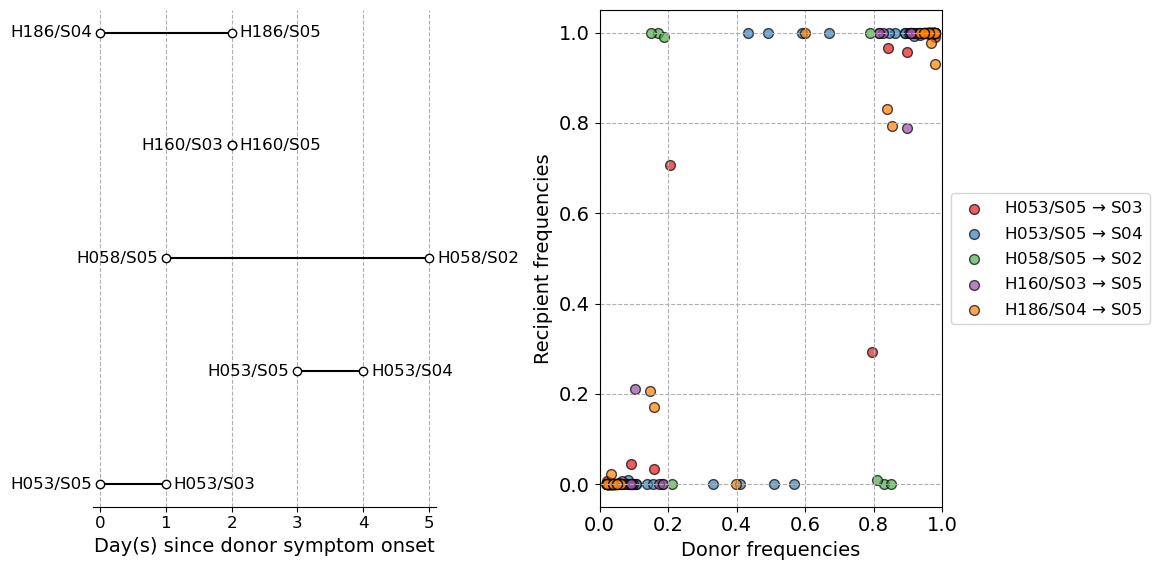

In [19]:
try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index("sampid")

with plt.style.context("default"):
    fig, axes = plt.subplots(1, 2, figsize=(11.7, 5.8))
    
    ax = axes[0]
    for yidx, idx in enumerate(transmission_variants_df.index): 
        
        index_subject, secondary_subject = idx
        transmitted_variants_list = transmission_variants_df.loc[(index_subject, secondary_subject), "transmitted_var_list"]
        y_val = yidx*0.3
        
        index_sampid = transmission_variants_df.loc[(idx, "index_sampid")]
        index_timepoint = int(meta_df.loc[index_sampid, "timepoint"])
        day_range = range(index_timepoint, int(index_timepoint+transmission_variants_df.loc[idx, "days_between_samples"]+1))

        ax.plot([day_range[0], day_range[-1]], 
                [y_val]*2, "-o", markerfacecolor='white', 
                color="k" if len(transmitted_variants_list) > 0 else "r")

        ax.text(index_timepoint-0.12, y_val, index_subject, va='center', ha='right', fontsize=12, color="k" if len(transmitted_variants_list) > 0 else "r")
        ax.text(index_timepoint+transmission_variants_df.loc[idx, "days_between_samples"]+0.12, y_val, secondary_subject, va='center', ha='left', 
                fontsize=12, color="k" if len(transmitted_variants_list) > 0 else "r")

    # remove spines
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # x-axis label
    ax.set_xlabel("Day(s) since donor symptom onset", fontsize=14)
    
    ax.set_xlim(-0.1, 5.1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.grid(ls='--', axis='x', which='major', zorder=0)
    
    ##########
    ax = axes[-1]
    color_scheme = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33"]

    for cidx, tv_idx in enumerate(transmission_variants_df.index): 
        x_values = []
        y_values = []

        index_subject, secondary_subject = tv_idx
        index_sampid = transmission_variants_df.loc[(tv_idx, "index_sampid")]
        secondary_sampid = transmission_variants_df.loc[(tv_idx, "secondary_sampid")]

        # index_vcf
        index_vcf = variant_call_df.loc[index_sampid].copy()
        
        # secondary map_nuc_results 
        secondary_map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(secondary_sampid)).set_index(["Gene", "Position"])
        secondary_map_nuc_results = secondary_map_nuc_results[secondary_map_nuc_results['Coverage']>=min_cov]

        for idx in index_vcf.index:

            idx_index_vcf = index_vcf.loc[idx]
            for donor_nuc_var in set(idx_index_vcf['nuc_var']):
                try: 
                    donor_nuc_freq = idx_index_vcf[idx_index_vcf['nuc_var']==donor_nuc_var]['nuc_prop'].iloc[0]
                except: 
                    donor_nuc_freq = idx_index_vcf['nuc_prop']

                try: 
                    recipient_nuc_freq = secondary_map_nuc_results.loc[idx][donor_nuc_var]/secondary_map_nuc_results.loc[idx]['Coverage']
                except:
                    continue

                x_values.append(donor_nuc_freq)
                y_values.append(recipient_nuc_freq)

            try: 
                donor_nuc_var = idx_index_vcf["nuc_consensus"].iloc[0]
            except: 
                donor_nuc_var = idx_index_vcf["nuc_consensus"]

            try: 
                donor_nuc_freq = (idx_index_vcf["nuc_consensus_freq"]/idx_index_vcf["nuc_coverage"]).iloc[0]
            except: 
                donor_nuc_freq = (idx_index_vcf["nuc_consensus_freq"]/idx_index_vcf["nuc_coverage"])
            
            try:
                recipient_nuc_freq = secondary_map_nuc_results.loc[idx][donor_nuc_var]/secondary_map_nuc_results.loc[idx]['Coverage']
            except:
                continue
                
            x_values.append(donor_nuc_freq)
            y_values.append(recipient_nuc_freq)

        ax.scatter(x_values, y_values, s=50, alpha=0.7,
                   label=r"{} $\to$ {}".format(index_subject, re.sub("H\d+/", "", secondary_subject)),
                   c=color_scheme[cidx], edgecolors='k')

    ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fontsize=12)
    ax.set_xlim(0, 1.)
    #ax.set_ylim(-0.0001, 0.005)

    # set ylabel, lim, ticks and scale
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.grid(ls="--", zorder=0, which="both")

    ax.set_xlabel("Donor frequencies", fontsize=14)
    ax.set_ylabel("Recipient frequencies", fontsize=14)
    
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.savefig('./results/figures/transmission_pairs_AB.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

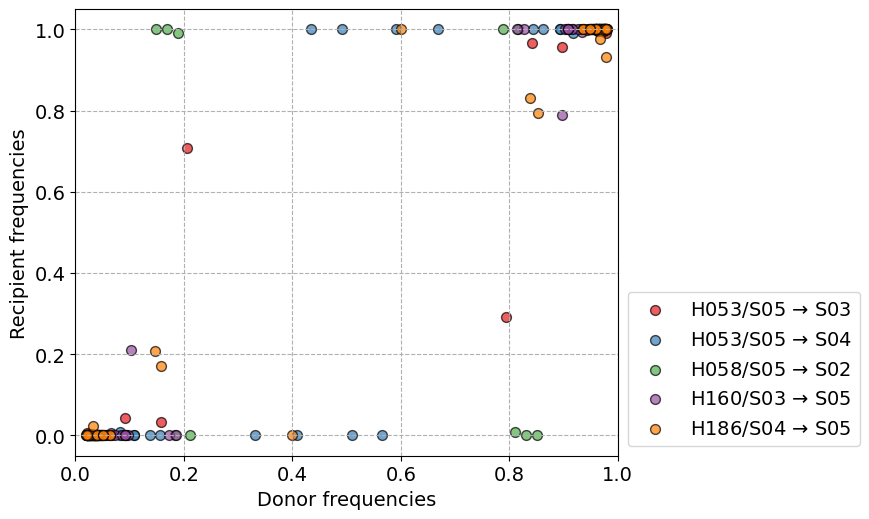

In [20]:
with plt.style.context("default"):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5.8))
    color_scheme = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33"]

    for cidx, tv_idx in enumerate(transmission_variants_df.index): 
        x_values = []
        y_values = []

        index_subject, secondary_subject = tv_idx
        index_sampid = transmission_variants_df.loc[(tv_idx, "index_sampid")]
        secondary_sampid = transmission_variants_df.loc[(tv_idx, "secondary_sampid")]

        # index_vcf
        index_vcf = variant_call_df.loc[index_sampid].copy()
        
        # secondary map_nuc_results 
        secondary_map_nuc_results = pd.read_csv("./results/map_nuc_results_%s.csv"%(secondary_sampid)).set_index(["Gene", "Position"])
        secondary_map_nuc_results = secondary_map_nuc_results[secondary_map_nuc_results['Coverage']>=min_cov]

        for idx in index_vcf.index:

            idx_index_vcf = index_vcf.loc[idx]
            for donor_nuc_var in set(idx_index_vcf['nuc_var']):
                try: 
                    donor_nuc_freq = idx_index_vcf[idx_index_vcf['nuc_var']==donor_nuc_var]['nuc_prop'].iloc[0]
                except: 
                    donor_nuc_freq = idx_index_vcf['nuc_prop']

                try: 
                    recipient_nuc_freq = secondary_map_nuc_results.loc[idx][donor_nuc_var]/secondary_map_nuc_results.loc[idx]['Coverage']
                except:
                    continue

                x_values.append(donor_nuc_freq)
                y_values.append(recipient_nuc_freq)

            try: 
                donor_nuc_var = idx_index_vcf["nuc_consensus"].iloc[0]
            except: 
                donor_nuc_var = idx_index_vcf["nuc_consensus"]

            try: 
                donor_nuc_freq = (idx_index_vcf["nuc_consensus_freq"]/idx_index_vcf["nuc_coverage"]).iloc[0]
            except: 
                donor_nuc_freq = (idx_index_vcf["nuc_consensus_freq"]/idx_index_vcf["nuc_coverage"])
            
            try:
                recipient_nuc_freq = secondary_map_nuc_results.loc[idx][donor_nuc_var]/secondary_map_nuc_results.loc[idx]['Coverage']
            except:
                continue
                
            x_values.append(donor_nuc_freq)
            y_values.append(recipient_nuc_freq)

        ax.scatter(x_values, y_values, s=50, alpha=0.7,
                   label=r"{} $\to$ {}".format(index_subject, re.sub("H\d+/", "", secondary_subject)),
                   c=color_scheme[cidx], edgecolors='k')

    ax.legend(loc='lower left',  bbox_to_anchor=(1, 0.), fontsize=14)
    ax.set_xlim(0, 1.)
    #ax.set_ylim(-0.0001, 0.005)

    # set ylabel, lim, ticks and scale
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.grid(ls="--", zorder=0, which="both")

    ax.set_xlabel("Donor frequencies", fontsize=14)
    ax.set_ylabel("Recipient frequencies", fontsize=14)

    plt.savefig('./results/figures/transmission_pairs_frequencies.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

In [21]:
if os.path.isfile("./results/pairwise_sampid_l1norm.csv"): 
    pairwise_l1norm_df = pd.read_csv("./results/pairwise_sampid_l1norm.csv")
else:
    try:
        set(meta_df["sampid"])
    except: 
        meta_df = meta_df.reset_index()

    def compute_L1_mpwrapper(sampid1, sampid2):
        
        if (sampid1, sampid2) in pairwise_l1norm or (sampid2, sampid1) in pairwise_l1norm: 
            return None 
        
        if os.path.isfile("./results/L1/L1_%s_%s.csv"%(sampid1, sampid2)) == True:
            return pd.read_csv("./results/L1/L1_%s_%s.csv"%(sampid1, sampid2))
        
        if os.path.isfile("./results/L1/L1_%s_%s.csv"%(sampid2, sampid1)) == True:
            return pd.read_csv("./results/L1/L1_%s_%s.csv"%(sampid2, sampid1))
        
        if (meta_df[meta_df['sampid']==sampid1][sorted_refnames]>min_breadth).all(axis=1).iloc[0] == False: 
            return None

        if (meta_df[meta_df['sampid']==sampid2][sorted_refnames]>min_breadth).all(axis=1).iloc[0] == False: 
            return None
        
        results_df = compute_L1_norm(sampid1, sampid2)
        if os.path.isdir("./results/L1") == False: 
            os.mkdir("./results/L1")
        results_df.to_csv("./results/L1/L1_%s_%s.csv"%(sampid1, sampid2), index=False)
        
        return results_df

    pool = mp.Pool(processes=threadnum)
    results = [pool.apply_async(compute_L1_mpwrapper, args=(sampid1, sampid2)) for sampid1, sampid2 in itertools.combinations(set(meta_df["sampid"]), 2)]
    output = [p.get() for p in results]

    for sidx, (sampid1, sampid2) in enumerate(list(itertools.combinations(set(meta_df["sampid"]), 2))): 
        if isinstance(output[sidx], pd.DataFrame):
            pairwise_l1norm[(sampid1, sampid2)] = output[sidx]

    pairwise_l1norm_df = []
    for (sampid1, sampid2) in pairwise_l1norm.keys(): 
        curr_pairwise_l1norm = pairwise_l1norm[(sampid1, sampid2)]
        curr_pairwise_l1norm['sampid1'] = sampid1
        curr_pairwise_l1norm['sampid2'] = sampid2
        pairwise_l1norm_df.append(curr_pairwise_l1norm)
    pairwise_l1norm_df = pd.concat(pairwise_l1norm_df, ignore_index=True)
    pairwise_l1norm_df.to_csv("./results/pairwise_sampid_l1norm.csv", index=False)

pairwise_l1norm_df = pairwise_l1norm_df.set_index(["sampid1", "sampid2"]).sort_index()
display (pairwise_l1norm_df.head())

gene     l1norm  genelen
sampid1 sampid2                           
2-18    3-1      1-PB2  14.303185     2172
        3-1      2-PB1   6.094118     2159
        3-1       3-PA   6.279045     2208
        3-1       4-HA   8.423736     1741
        3-1       5-NP   8.265370     1507

In [23]:
# read haplotype_df 
haplotype_df = pd.read_csv("./results/haplotype_reconstruct_df.csv")
haplotype_df = haplotype_df.set_index("sampid")

# how many transmitted haplotypes
tpairidx_to_haplotype_dist = {}
for idx in transmission_variants_df.index: 
    index_sampid = transmission_variants_df.loc[idx, "index_sampid"]
    secondary_sampid = transmission_variants_df.loc[idx, "secondary_sampid"]
    
    # of the transmitted variants, how many haplotypes in the donor has those specific variants 
    for var_info in transmission_variants_df.loc[idx, "transmitted_var_list"]: 
        gene, position, nuc_var = var_info[:3]
        
        donor_haplotype_df = haplotype_df.loc[index_sampid].copy().reset_index().set_index("gene")
        var_pos_in_gene = eval(donor_haplotype_df.loc[gene, "nuc_pos"])
        var_pos_in_gene_idx = var_pos_in_gene.index(position)
        
        number_of_donor_haplotypes_with_var = len([haplotype for haplotype in eval(donor_haplotype_df.loc[gene, "haplotype"]) if haplotype[var_pos_in_gene_idx]==nuc_var])
        try: 
            tpairidx_to_haplotype_dist[idx].append(number_of_donor_haplotypes_with_var)
        except: 
            tpairidx_to_haplotype_dist[idx] = [number_of_donor_haplotypes_with_var]

print (tpairidx_to_haplotype_dist)
print ("grand median", np.median([np.median(haplotype_dist) for tpair, haplotype_dist in tpairidx_to_haplotype_dist.items()]))
median_list = [np.median(haplotype_dist) for tpair, haplotype_dist in tpairidx_to_haplotype_dist.items()]
print ("iqr of median", np.percentile(median_list, [25, 75]))

{('H053/S05', 'H053/S03'): [1, 1, 1], ('H053/S05', 'H053/S04'): [2, 2], ('H058/S05', 'H058/S02'): [1, 1, 1], ('H160/S03', 'H160/S05'): [1], ('H186/S04', 'H186/S05'): [1, 1, 1]}
grand median 1.0
iqr of median [1. 1.]


/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


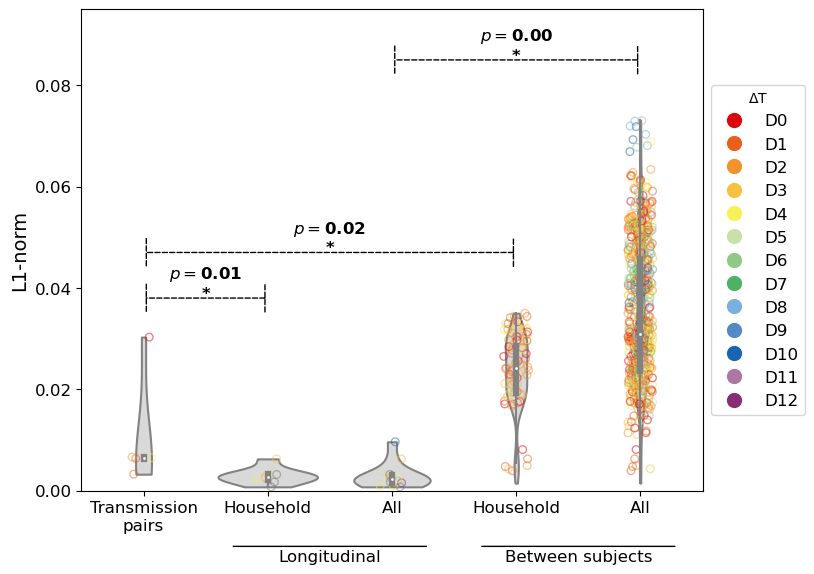

In [24]:
import seaborn as sns
from matplotlib.collections import PathCollection
from matplotlib.lines import Line2D

# get array 
def get_l1norm(sampid1, sampid2): 
    try:
        curr_l1norm_df = pairwise_l1norm_df.loc[(sampid1, sampid2)]
    except:
        try: 
            curr_l1norm_df = pairwise_l1norm_df.loc[(sampid2, sampid1)]
        except: 
            return None
    return (curr_l1norm_df['l1norm']/curr_l1norm_df['genelen']).sum()

 
all_l1_array = []
color_dict = {-1:"#777777", 0:"#dc050c", 1:"#e8601c", 2:"#f1932d", 3:"#f6c141", 4:"#f7f056", 5:"#cae0ab",
              6:"#90c987", 7:"#4eb265", 8:"#7bafde", 9:"#5289c7", 10:"#1965b0", 11:"#ae76a3", 12:"#882e72"}

# transmission pairs sampid
try:
    meta_df = meta_df.reset_index()
except:
    pass
meta_df = meta_df.set_index("sampid")
transmission_pairs_list = [(row.index_sampid, row.secondary_sampid) for r, row in transmission_variants_df.iterrows()]
for sampid1, sampid2 in transmission_pairs_list: 
    l1norm = get_l1norm(sampid1, sampid2)
    if l1norm == None:
        continue
    sampid1_tp = meta_df.loc[sampid1, "enrolD"]
    sampid2_tp = meta_df.loc[sampid2, "enrolD"]
    all_l1_array.append({"l1norm":l1norm, "x_var":"TP", "color":abs(sampid1_tp-sampid2_tp)})

# longitudinal - Household 
for subject_id in set(hh_meta.index.get_level_values(1)):
    subject_hh_meta = hh_meta.xs(subject_id, level=1)
    if len(subject_hh_meta) < 2: 
        continue 
    else: 
        enrolD_list = sorted(set(subject_hh_meta.index.get_level_values(1)))
        for secondD in enrolD_list[1:]:
            sampid1 = subject_hh_meta.xs(enrolD_list[0], level=1).sampid.iloc[0]
            sampid2 = subject_hh_meta.xs(secondD, level=1).sampid.iloc[0]
            timepoint = subject_hh_meta.xs(secondD, level=1).timepoint.iloc[0]
            if pd.isna(timepoint): 
                timepoint = -1
                
            l1norm = get_l1norm(sampid1, sampid2)
            if l1norm == None:
                continue
            all_l1_array.append({"l1norm":l1norm, "x_var":"Household_L", "color":timepoint})
            
# longitudinal - All 
temp_meta_df = meta_df.copy().reset_index().set_index(["household", "subject_id", "enrolD"])
for subject_id in set(temp_meta_df.index.get_level_values(1)):
    subject_temp_meta = temp_meta_df.xs(subject_id, level=1)
    if len(subject_temp_meta) < 2: 
        continue 
    else: 
        enrolD_list = sorted(set(subject_temp_meta.index.get_level_values(1)))
        for secondD in enrolD_list[1:]:
            sampid1 = subject_temp_meta.xs(enrolD_list[0], level=1).sampid.iloc[0]
            sampid2 = subject_temp_meta.xs(secondD, level=1).sampid.iloc[0]
            timepoint = subject_temp_meta.xs(secondD, level=1).timepoint.iloc[0]
            if pd.isna(timepoint): 
                timepoint = -1
                
            l1norm = get_l1norm(sampid1, sampid2)
            if l1norm == None:
                continue
            all_l1_array.append({"l1norm":l1norm, "x_var":"All", "color":timepoint})

            
# between subjects in household
for subject1, subject2 in itertools.combinations(set(hh_meta.index.get_level_values(1)), 2):

    if (subject1, subject2) in transmission_variants_df.index or (subject2, subject1) in transmission_variants_df.index: 
        #print ((subject1, subject2))
        continue 

    subject1_sampid = list(hh_meta.xs(subject1, level=1)['sampid'])
    subject2_sampid = list(hh_meta.xs(subject2, level=1)['sampid'])

    for (sampid1, sampid2) in itertools.product(subject1_sampid, subject2_sampid):

        sampid1_tp = meta_df.loc[sampid1, "timepoint"]
        sampid2_tp = meta_df.loc[sampid2, "timepoint"]
        """if sampid1_tp != sampid2_tp: # samples compared must be of the same timepoint 
            continue""" 

        l1norm = get_l1norm(sampid1, sampid2)
        if l1norm == None:
            continue

        all_l1_array.append({"l1norm":l1norm, "x_var":"Household_BS", "color":abs(sampid1_tp-sampid2_tp)})
        
# between subjects (all)
temp_meta = meta_df.copy().reset_index().set_index(["household", "subject_id", "enrolD"])
for subject1, subject2 in itertools.combinations(set(temp_meta.index.get_level_values(1)), 2):

    if (subject1, subject2) in transmission_variants_df.index or (subject2, subject1) in transmission_variants_df.index: 
        #print ((subject1, subject2))
        continue 

    subject1_sampid = list(temp_meta.xs(subject1, level=1)['sampid'])
    subject2_sampid = list(temp_meta.xs(subject2, level=1)['sampid'])

    for (sampid1, sampid2) in itertools.product(subject1_sampid, subject2_sampid):

        sampid1_tp = meta_df.loc[sampid1, "timepoint"]
        sampid2_tp = meta_df.loc[sampid2, "timepoint"]
        """if sampid1_tp != sampid2_tp: # samples compared must be of the same timepoint 
            continue""" 

        l1norm = get_l1norm(sampid1, sampid2)
        if l1norm == None:
            continue

        all_l1_array.append({"l1norm":l1norm, "x_var":"All_BS", "color":abs(sampid1_tp-sampid2_tp)})

all_l1_array = pd.DataFrame.from_dict(all_l1_array)

with plt.style.context("default"):
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 5.8))
    
    vp = sns.violinplot(x="x_var", y="l1norm", data=all_l1_array, color="0.85", 
                   ax=ax, alpha=0.5, cut=0)
    for artist in vp.lines:
        artist.set_zorder(10)
    for artist in vp.findobj(PathCollection):
        artist.set_zorder(11)
    
    pts = np.linspace(0, np.pi * 2, 24)
    circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
    vert = np.r_[circ, circ[::-1] * .7]
    open_circle = matplotlib.path.Path(vert)
    sns.stripplot(x="x_var", y="l1norm", data=all_l1_array, jitter=True, size=6.5,
                  alpha=0.5, hue="color", palette=color_dict, ax=ax, marker=open_circle)
    
    ax.get_legend().remove()

    ax.tick_params(which="both", labelsize=12)
    
    ax.set_ylabel("L1-norm", fontsize=14)
    ax.set_xlabel("")
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label="D%i"%(d), 
                              markerfacecolor=color_dict[d], markersize=12) for d in range(0, 13)]
    # Put a legend below current axis
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="$\Delta$T")
    
    full_labels = ["Transmission\npairs", "Household", "All", "Household", "All", "Mild", "Severe", 'Mild v.\nSevere', "HCMC"]
    ax.set_xticklabels(full_labels[:len(set(all_l1_array['x_var']))])
    
    ######### annotate p-values  #########
    ax.annotate('', xy=(0, 0.047),
                xytext=(3, 0.047),
                arrowprops=dict(arrowstyle='|-|', ls="--", facecolor='red'),          
                annotation_clip=False)  
    pval = mannwhitneyu(all_l1_array[all_l1_array["x_var"]=="TP"]["l1norm"], all_l1_array[all_l1_array["x_var"]=="Household_BS"]["l1norm"]).pvalue
    ax.annotate("$p=$%.2f\n*"%pval, fontsize=12,
                xy=(1.5, 0.05), weight="bold",
                xytext=(1.5, 0.05), 
                ha='center', va='center',
                annotation_clip=False)
    
    ax.annotate('', xy=(0, 0.038),
                xytext=(1, 0.038),
                arrowprops=dict(arrowstyle='|-|', ls="--", facecolor='red'),          
                annotation_clip=False)  
    pval = mannwhitneyu(all_l1_array[all_l1_array["x_var"]=="TP"]["l1norm"], all_l1_array[all_l1_array["x_var"]=="Household_L"]["l1norm"]).pvalue
    ax.annotate("$p=$%.2f\n*"%pval, fontsize=12,
                xy=(0.5, 0.041), weight="bold",
                xytext=(0.5, 0.041), 
                ha='center', va='center',
                annotation_clip=False)
    
    ax.annotate('', xy=(2, 0.085),
                xytext=(4, 0.085),
                arrowprops=dict(arrowstyle='|-|', ls="--", facecolor='red'),          
                annotation_clip=False)  
    pval = mannwhitneyu(all_l1_array[all_l1_array["x_var"]=="All_L"]["l1norm"], all_l1_array[all_l1_array["x_var"]=="All_BS"]["l1norm"]).pvalue
    ax.annotate("$p=$%.2f\n*"%pval, fontsize=12,
                xy=(3, 0.088), weight="bold",
                xytext=(3, 0.088), 
                ha='center', va='center',
                annotation_clip=False)
    #print (mannwhitneyu(all_l1_array[all_l1_array["x_var"]=="All_L"]["l1norm"], all_l1_array[all_l1_array["x_var"]=="All_BS"]["l1norm"]))
    
    ax.annotate('', xy=(0.7, -0.011),
                xytext=(2.3, -0.011),
                arrowprops=dict(arrowstyle='-',facecolor='red'),          
                annotation_clip=False)  
    
    ax.annotate("Longitudinal", fontsize=12,
                xy=(1.5, -0.013),
                xytext=(1.5, -0.013), 
                ha='center', va='center',
                annotation_clip=False)
    
    ax.annotate('', xy=(2.7, -0.011),
                xytext=(4.3, -0.011),
                arrowprops=dict(arrowstyle='-',facecolor='red'),          
                annotation_clip=False)  
    
    ax.annotate("Between subjects", fontsize=12,
                xy=(3.5, -0.013),
                xytext=(3.5, -0.013), 
                ha='center', va='center',
                annotation_clip=False)
    
    ax.set_ylim(0., 0.095)
    plt.tight_layout()
    plt.savefig('./results/figures/l1norm_violinplots.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()